### NN Vector Pull for Direction

Fig 4a - cosine angle of updates analysis

##### Summary
Load any NN model. Obtain layer by layer the unit direction vector (against vector of zeros). See if cosine similarity can be used as a metric to measure direction.

In [1]:
cd /home/ubuntu/fedatk_unl_tj/

/home/ubuntu/fedatk_unl_tj


In [2]:
# Import General Libraries
import os
import argparse
import torch
import copy
import pickle
import random
import numpy as np
import pandas as pd

# Import FedEM based Libraries
from utils.utils import *
from utils.constants import *
from utils.args import *
from utils.util_notebooks import *
from run_experiment import *
from models import *

# Import Transfer Attack
from transfer_attacks.Personalized_NN import *
from transfer_attacks.Params import *
from transfer_attacks.Transferer import *
from transfer_attacks.Args import *
from transfer_attacks.TA_utils import *

/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ubuntu/anaconda3/envs/FedEM_env/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
setting, num_user = "FedAvg_adv", 20

try: # Skip loading if already loaded
    aggregator
except:
    aggregator, clients, args_ = set_args(setting, num_user,  experiment = "fakenewsnet") # Indicate dataset here

# Load models for FAT and FedAvg
save_path_FAT = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FAT_ep02/'
save_path_FedAvg = '/home/ubuntu/fedatk_unl_tj/weights/fakenews/250119_small_architecture_moreconv/FedAvg/'

model_FAT = copy.deepcopy(import_model_weights(num_user, setting, save_path_FAT, aggregator, args_)[0])
model_Fedavg = import_model_weights(num_user, setting, save_path_FedAvg, aggregator, args_)[0]


==> Clients initialization..
===> Building data iterators..


 95%|█████████▌| 19/20 [00:01<00:00, 16.68it/s]


===> Initializing clients..


100%|██████████| 20/20 [00:01<00:00, 17.90it/s]
/home/ubuntu/fedatk_unl_tj/aggregator.py:288: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  learner.model.load_state_dict(tor

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

def matrix_cosine_similarity(mat1, mat2):
    vec1 = mat1.cpu().numpy().flatten()
    vec2 = mat2.cpu().numpy().flatten()
    return cosine_similarity([vec1], [vec2])[0][0]

def get_diff_NN( model1, model2, desired_keys):

    param_model1 = model1.state_dict()
    param_model2 = model2.state_dict()

    mag_norm_122 = []
    for key in desired_keys: #params_FAT:

        diff = param_model1[key] - param_model2[key]
        l2_norm = torch.norm(diff, p=2)

        mag_norm_122 += [diff/torch.norm(diff,p=2)]
    return mag_norm_122

def diff_cosine_similarity(diff, baseline, key_length):
    values_stored = np.zeros(key_length)

    for i in range(key_length):
        values_stored[i] = matrix_cosine_similarity(diff[i], baseline[i])

    return values_stored 

def get_adv_acc(aggregator, model, batch_size = 500, data_mode = "all", c_id = 0, eps = 0.1):
    num_clients = len(aggregator.clients)

    # Dataloader for datax
    data_x = []
    daniloader = clients[0].val_iterator
    for (x,y,idx) in daniloader.dataset:
        data_x.append(x)

    data_x = torch.stack(data_x)
    victim_idxs = range(num_clients)

    # Save matrix
    test_acc_save = np.zeros([1])
    adv_acc_save = np.zeros([1])

    dataloader = load_client_data(clients = aggregator.clients, c_id = c_id, mode = data_mode)
    batch_size = min(batch_size, dataloader.y_data.shape[0])

    t1 = Transferer(models_list = [model] * num_clients, dataloader=dataloader)
    t1.generate_victims(victim_idxs)
    t1.atk_params = PGD_Params()
    t1.atk_params.set_params(batch_size=batch_size, iteration = 10, target = -1,
                            x_val_min = torch.min(data_x), x_val_max = torch.max(data_x),
                            step_size = 0.05, step_norm = "inf", eps = eps, eps_norm = 2)
    t1.generate_advNN(c_id)
    t1.generate_xadv(atk_type="pgd")
    t1.send_to_victims(victim_idxs)
    test_acc_save[0] = t1.orig_acc_transfers[0]
    adv_acc_save[0] = t1.adv_acc_transfers[0]

    return test_acc_save, adv_acc_save

def pull_model_from_agg(aggregator):
        
    # This is where the models are stored -- one for each mixture --> learner.model for nn
    hypotheses = aggregator.global_learners_ensemble.learners

    # obtain the state dict for each of the weights 
    weights_h = []

    for h in hypotheses:
        weights_h += [h.model.state_dict()]
    
    # first make the model with empty weights
    new_model = copy.deepcopy(hypotheses[0].model)
    return new_model

In [5]:
# Obtain parameters for each layer
params_FAT = model_FAT.state_dict()
params_FedAvg = model_Fedavg.state_dict()

# Just take the values of weights and bias for the model
desired_keys = [key for key in params_FAT.keys() if 'weight' in key or 'bias' in key]

In [6]:
# Find mag norm 
mag_norm_FedAvg2FAT = []
for key in desired_keys: #params_FAT:

    diff = params_FAT[key] - params_FedAvg[key]
    l2_norm = torch.norm(diff, p=2)

    mag_norm_FedAvg2FAT += [diff/torch.norm(diff,p=2)]


In [7]:
# Perform 50 rounds of full overfitting on benign data on 200R FAT model
num_rounds = 100

setting = 'FedAvg_adv'

test_acc_gather = []
adv_acc_gather = []
cosine_gather_layers = np.zeros([num_rounds, len(desired_keys)])

save_path_FAT150 = save_path_FAT # 'weights/cifar10/231031_FAT150round/FAT/'

aggregator, clients, args_ = set_args(setting, num_user, experiment = "fakenewsnet")

# Test performance of aggregator on data 
aggregator.load_state(dir_path = save_path_FAT150)
aggregator.update_clients()
model_FAT = pull_model_from_agg(aggregator)
model_FAT.eval()
acc, adv_acc = get_adv_acc(aggregator, model_FAT)

prev_model = copy.deepcopy(model_FAT)

print("Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
test_acc_gather+= [np.mean(acc)]
adv_acc_gather += [np.mean(adv_acc)]

# Setting evasion attack parameters
x_min = torch.min(clients[0].adv_nn.dataloader.x_data)
x_max = torch.max(clients[0].adv_nn.dataloader.x_data)
atk_params = PGD_Params()
atk_params.set_params(batch_size=1, iteration = 10,
                target = -1, x_val_min = x_min, x_val_max = x_max,
                step_size = 0.05, step_norm = "inf", eps = 0.1, eps_norm = 2)


for i in range(num_rounds):
    # if i%2 == 0: # UNCOMMENT IF ADDING FAT PROCEDURE TO CALCULATION
    #     # add adv dataset update
    #     G = 0.5
    #     Fu = np.ones(num_user) * G

    #     # Assign proportion and attack params
    #     for c in range(len(clients)):
    #         aggregator.clients[c].set_unhard(unhard = True, unharden_portion = 0.5)
    #         aggregator.clients[c].set_adv_params(Fu[c], atk_params)
    #         aggregator.clients[c].update_advnn()
    #         aggregator.clients[c].assign_advdataset()

    aggregator.mix()
    model_overfit = pull_model_from_agg(aggregator)
    model_overfit.eval()
    acc, adv_acc = get_adv_acc(aggregator, model_overfit)

    diffnn = get_diff_NN(prev_model, model_overfit, desired_keys)

    cosine_gather_layers[i,:] = diff_cosine_similarity(diffnn, mag_norm_FedAvg2FAT, len(desired_keys))
    print("round", i,"Test acc: ", np.mean(acc), "adv acc: ", np.mean(adv_acc))
    test_acc_gather+= [np.mean(acc)]
    adv_acc_gather += [np.mean(adv_acc)]
    prev_model = copy.deepcopy(model_overfit)
    # Perform gradient direction gathering




==> Clients initialization..
===> Building data iterators..


 95%|█████████▌| 19/20 [00:01<00:00, 18.36it/s]


===> Initializing clients..


100%|██████████| 20/20 [00:00<00:00, 40.24it/s]


Test acc:  0.7300000190734863 adv acc:  0.42600002884864807


/home/ubuntu/fedatk_unl_tj/learners/learner.py:190: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  loss = (loss_vec.T @ weights[indices]) / loss_vec.size(0)


round 0 Test acc:  0.6780000329017639 adv acc:  0.3760000169277191
round 1 Test acc:  0.6940000057220459 adv acc:  0.3760000169277191
round 2 Test acc:  0.7320000529289246 adv acc:  0.3840000033378601
round 3 Test acc:  0.7220000624656677 adv acc:  0.5220000147819519
round 4 Test acc:  0.7160000205039978 adv acc:  0.4360000193119049
round 5 Test acc:  0.7360000610351562 adv acc:  0.45600003004074097
round 6 Test acc:  0.7780000567436218 adv acc:  0.46000000834465027
round 7 Test acc:  0.7440000176429749 adv acc:  0.4620000123977661
round 8 Test acc:  0.7640000581741333 adv acc:  0.4540000259876251
round 9 Test acc:  0.7420000433921814 adv acc:  0.43800002336502075
round 10 Test acc:  0.7260000109672546 adv acc:  0.4140000343322754
round 11 Test acc:  0.7580000162124634 adv acc:  0.45000001788139343
round 12 Test acc:  0.7300000190734863 adv acc:  0.41600000858306885
round 13 Test acc:  0.7660000324249268 adv acc:  0.4440000355243683
round 14 Test acc:  0.7320000529289246 adv acc:  0.41

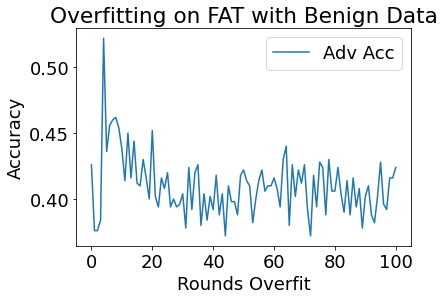

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = range(len(test_acc_gather))  # 100 points from 0 to 10
y1 = test_acc_gather               # Sine function for the first line
y2 = adv_acc_gather             # Cosine function for the second line

# Plotting the lines
# plt.plot(x, y1, label='Test Acc')
plt.plot(x, y2, label='Adv Acc')

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Accuracy')
plt.title('Overfitting on FAT with Benign Data')

# Adding a legend
plt.legend()

# Display the plot
plt.show()


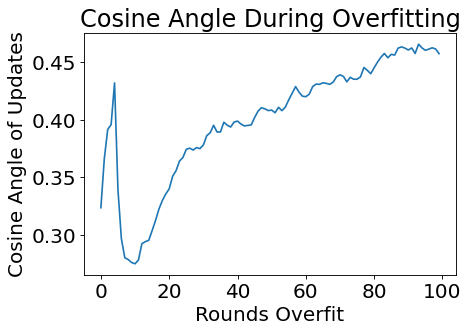

In [13]:
np.mean(cosine_gather_layers,axis = 1)

import matplotlib.pyplot as plt
import numpy as np

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

# Generate some sample data
y1 = np.mean(cosine_gather_layers,axis = 1)
x = range(len(y1))  # 100 points from 0 to 10


# Plotting the lines
plt.plot(x, y1)

# Adding labels and title
plt.xlabel('Rounds Overfit')
plt.ylabel('Cosine Angle of Updates')
plt.title('Cosine Angle During Overfitting')

# Adding a legend
# plt.legend()

# Display the plot
plt.show()


In [14]:
# Get number of params per desired key
size = np.zeros(len(desired_keys))
i = 0
for key in desired_keys:
    size[i]=params_FAT[key].flatten().shape[0]
    i += 1

prop = size/np.sum(size)

cosine_propped = np.zeros(cosine_gather_layers.shape)

# for t in range(num_rounds):
#     cosine_propped[t,:] = np.average(cosine_gather_layers[t,:], weights = prop)

np.average(cosine_gather_layers, weights = prop, axis = 1)

array([0.11, 0.14, 0.15, 0.14, 0.26, 0.18, 0.15, 0.12, 0.11, 0.10, 0.10,
       0.11, 0.11, 0.12, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.20,
       0.21, 0.22, 0.24, 0.25, 0.27, 0.28, 0.28, 0.28, 0.28, 0.30, 0.30,
       0.31, 0.32, 0.32, 0.32, 0.33, 0.33, 0.33, 0.33, 0.34, 0.34, 0.34,
       0.34, 0.34, 0.35, 0.35, 0.35, 0.35, 0.36, 0.36, 0.37, 0.37, 0.37,
       0.38, 0.37, 0.37, 0.37, 0.38, 0.38, 0.38, 0.39, 0.38, 0.38, 0.39,
       0.39, 0.39, 0.39, 0.39, 0.40, 0.40, 0.40, 0.41, 0.41, 0.40, 0.40,
       0.40, 0.41, 0.41, 0.42, 0.42, 0.43, 0.43, 0.43, 0.43, 0.43, 0.42,
       0.42, 0.42, 0.43, 0.44, 0.43, 0.43, 0.43, 0.44, 0.44, 0.44, 0.44,
       0.44])

Text(0.5, 1.0, 'Per Layer Cosine Angle Round 1')

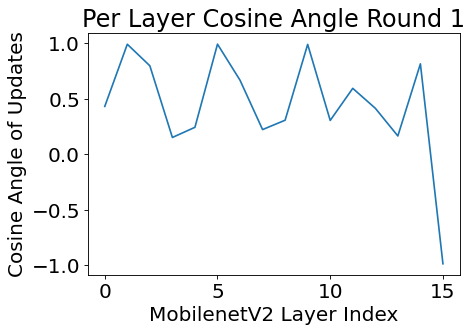

: 

In [ ]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)
plt.figure(dpi=80, figsize=(6,4))

plt.plot(cosine_gather_layers[80])

# Adding labels and title
plt.xlabel('MobilenetV2 Layer Index')
plt.ylabel('Cosine Angle of Updates')
plt.title('Per Layer Cosine Angle Round 1')